### RQ1: tISC in rTPJ

#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from nilearn import input_data, datasets, plotting
from nilearn.input_data import NiftiMasker
import nilearn, pickle, sys, os
import seaborn as sns
import pandas as pd
from utils import *
import nibabel as nib
#from nilearn.image import new_img_like, load_img, get_data
sns.set_style('white')


/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


#### Set up segments
see paper for details on scene coding

In [2]:
act_segments = [ 'Act  A    0:14 1:30    Secs( 14 -  90)   TRs (  7 -  45)   Premise: Clouds produce babies and storks deliver them',
                 'Act  B    1:30 3:53    Secs( 90 - 233)   TRs ( 45 - 116)   Rising Action: Gus, the cloud, makes bad babies, which hurt Peck, the stork',
                 'Act C/D   3:53 4:35    Secs(233 - 275)   TRs (116 - 138)   Conflict/Resolution & Climax: Peck leaves for another cloud, Gus is sad',
                 'Act  E    4:35 5:14    Secs(275 - 314)   TRs (138 - 157)   Fall Out: Peck returns. He carries protective gear. Happily ever after ']

onsets = np.array([7, 45, 116, 138])
print('Onsets: ' + str(onsets))

offsets = np.hstack((onsets[1:], 157))
print('Offsets: ' + str(offsets))


onsets = onsets + 5 + 2   # the onset and hrf delay
print('Shifted Onsets: ' + str(onsets))
offsets = offsets + 5 + 2   
print('Shifted Offsets: ' + str(offsets))

n_bins = len(onsets)
n_bins

Onsets: [  7  45 116 138]
Offsets: [ 45 116 138 157]
Shifted Onsets: [ 14  52 123 145]
Shifted Offsets: [ 52 123 145 164]


4

### Run segment-wise ISC

In [3]:
# load data
current_array_filename = '../data/ts_array_shen268_regional_average_ages13-99.npy'

# swap axes 
ts_array = np.load(current_array_filename)
print(ts_array.shape)

n_subjs = ts_array.shape[0]
print(n_subjs)

print(ts_array.shape)
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print(ts_data.shape)

stacked_res = []
stacked_res_cond_vec = []
segment_iscs = np.zeros( n_bins)
a = []
b = []


relevant_region  = 47 #this is the rTPJ - see other notebook

# loop over segments
for curr_bin in range(4):#2,4, 1):
            print('current bin' + str(curr_bin) )

            curr_data = np.squeeze(ts_data[onsets[curr_bin]:offsets[curr_bin], relevant_region, : ])
            #print('current data shape: ' + str(curr_data.shape) )

            #curr_res = partly_isc(curr_data, 
            #                      summary_statistic=np.mean)

            #segment_iscs[curr_bin] = curr_res[0]
            #print(segment_iscs)
            
            curr_res = partly_isc(curr_data, summary_statistic=np.mean)
            a.append(curr_res[0])
            print(curr_res)
            
            curr_res = partly_isc(curr_data, pairwise = False)
            stacked_res.append(np.arctanh(partly_isc(curr_data, pairwise = False)))
            stacked_res_cond_vec.append((np.ones(curr_res.shape[0]) * curr_bin).T)
            b.append(np.tanh(np.mean(np.arctanh(curr_res), axis=0))[np.newaxis, :][0])
            print(np.mean(curr_res))

(33, 168, 268)
33
(33, 168, 268)
(168, 268, 33)
current bin0
Assuming 33 subjects with 38 time points and 1 voxel(s) or ROI(s).
[[0.2135208]]
Assuming 33 subjects with 38 time points and 1 voxel(s) or ROI(s).
Assuming 33 subjects with 38 time points and 1 voxel(s) or ROI(s).
0.2039813575228261
current bin1
Assuming 33 subjects with 71 time points and 1 voxel(s) or ROI(s).
[[0.39118979]]
Assuming 33 subjects with 71 time points and 1 voxel(s) or ROI(s).
Assuming 33 subjects with 71 time points and 1 voxel(s) or ROI(s).
0.3731002485692174
current bin2
Assuming 33 subjects with 22 time points and 1 voxel(s) or ROI(s).
[[0.26280503]]
Assuming 33 subjects with 22 time points and 1 voxel(s) or ROI(s).
Assuming 33 subjects with 22 time points and 1 voxel(s) or ROI(s).
0.2447123765173375
current bin3
Assuming 33 subjects with 19 time points and 1 voxel(s) or ROI(s).
[[0.25981225]]
Assuming 33 subjects with 19 time points and 1 voxel(s) or ROI(s).
Assuming 33 subjects with 19 time points and 1 

In [4]:
ISC = np.asarray(stacked_res).flatten()
cond = np.asarray(stacked_res_cond_vec).flatten()
print(ISC.shape)
print(cond.shape)

(132,)
(132,)


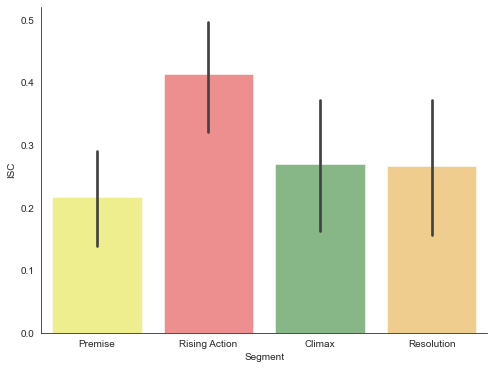

In [7]:
df = pd.DataFrame(ISC, columns = ['ISC'])
df['Segment'] = cond
df

x = np.arange(segment_iscs.shape[0])

fill_color = ['yellow', 'red','green','orange']

plt.figure(figsize = (8,6))

ax = sns.barplot(x="Segment", y="ISC", data=df,
                palette = fill_color, alpha = 0.5)
plt.xticks(x, ['Premise','Rising Action','Climax','Resolution']);

sns.despine()